<div style="direction:rtl">ایجاد یک لوله کلاسترینگ K-Means</div>
<div style="direction:rtl">اگر بخواهید با یک فضای نام تازه شروع کنید، همهٔ ماژول‌های مورد نیاز برای ساخت و ارزیابی لوله کلاسترینگ را وارد کنید، شامل پاندا و سی بورن برای بصری‌سازی‌های پیشرفتهٔ بیشتر:</div>


In [1]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

<div style="direction:rtl">مجموعه داده TCGA را از UCI دانلود و استخراج کنید:</div>

In [2]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

<div style="direction:rtl">پس از اتمام دانلود و استخراج، باید یک دایرکتوری مشابه زیر داشته باشید:</div>

TCGA-PANCAN-HiSeq-801x20531/
|
├── data.csv
└── labels.csv


<div style="direction:rtl">کلاس KMeans در scikit-learn نیازمند یک آرایه NumPy به عنوان ورودی است. پکیج NumPy یک تابع کمکی برای بارگذاری داده از فایل متنی به حافظه به عنوان آرایه‌های NumPy دارد:</div>

In [2]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = np.genfromtxt(
    datafile,
    delimiter=",",
    usecols=range(1, 20532),
    skip_header=1
)

true_label_names = np.genfromtxt(
    labels_file,
    delimiter=",",
    usecols=(1,),
    skip_header=1,
    dtype="str"
)


<div style="direction:rtl">اطلاعات ستون اول تا سوم برای پنج نمونه اول و همچنین برچسب‌ها برای پنج نمونه اول را بررسی کنید:</div>

In [3]:
data[:5, :3]

array([[0.        , 2.01720929, 3.26552691],
       [0.        , 0.59273209, 1.58842082],
       [0.        , 3.51175898, 4.32719872],
       [0.        , 3.66361787, 4.50764878],
       [0.        , 2.65574107, 2.82154696]])

In [4]:
true_label_names[:5]

array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype='<U4')


<div style="direction:rtl">متغیر داده تمام مقادیر بیان‌شدهٔ ژن از 20,531 ژن را شامل می‌شود. نام‌های واقعی برچسب‌ها نوع‌های سرطان برای هر یک از 881 نمونه هستند. رکورد اول در داده با اولین برچسب در برچسب‌های واقعی مطابقت دارد.</div>

<div style="direction:rtl">برچسب‌ها رشته‌های حاوی کوتاه‌نویسی‌های انواع سرطان هستند:</div>


<div style="direction:rtl">BRCA: سرطان پستان</div>
<div style="direction:rtl">COAD: آدنوکارسینوم کولون</div>
<div style="direction:rtl">KIRC: سرطان سلولی واضح کلیه</div>
<div style="direction:rtl">LUAD: آدنوکارسینوم ریه</div>
<div style="direction:rtl">PRAD: آدنوکارسینوم پروستات</div>
<div style="direction:rtl">برای استفاده از این برچسب‌ها در روش‌های ارزیابی، ابتدا باید اختصارها را به اعداد صحیح تبدیل کنید با استفاده از LabelEncoder:</div>

In [5]:
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)

true_labels[:5]

array([4, 3, 4, 4, 0], dtype=int64)


<div style="direction:rtl">از زمانی که label_encoder به داده منطبق شده است، می‌توانید کلاس‌های منحصر به فرد نمایش داده شده با .classes_ را ببینید. طول آرایه را در متغیر n_clusters برای استفاده بعدی ذخیره کنید:</div>

In [6]:
label_encoder.classes_


n_clusters = len(label_encoder.classes_)

<div style="direction:rtl">در لوله‌های عملی یادگیری ماشین، متداول است که داده‌ها قبل از ورود به الگوریتم کلاسترینگ، چندین دنباله از تبدیلات را طی کنند. شما در این آموزش از اهمیت یکی از این مراحل تبدیلات، مقیاس ویژگی، در ابتدای آموزش خود آگاه شدید. یک تکنیک مهم دیگر در تبدیل داده، کاهش بعد است که تعداد ویژگی‌ها را در مجموعه داده با حذف یا ترکیب آن‌ها کاهش می‌دهد.

تکنیک‌های کاهش بعد به حل یک مشکل در الگوریتم‌های یادگیری ماشین که به نام نفر آبابعیت شناخته می‌شود، کمک می‌کنند. به طور خلاصه، با افزایش تعداد ویژگی‌ها، فضای ویژگی پراکنده می‌شود. این پراکندگی باعث مشکل می‌شود تا الگوریتم‌ها نتوانند اشیاء داده را در نزدیکی یکدیگر در فضای بعد بالاتر پیدا کنند. از آنجا که مجموعه داده بیان‌شده حاوی بیش از 20,000 ویژگی است، به عنوان یک کاندید عالی برای کاهش بعد محسوب می‌شود.

تجزیه و تحلیل مؤلفه‌های اصلی (PCA) یکی از تکنیک‌های کاهش بعد است. PCA داده ورودی را با پروژه‌سازی آن به تعداد کمتری از ابعاد به نام مؤلفه‌ها تبدیل می‌کند. این مؤلفه‌ها تنوع داده ورودی را از طریق ترکیب خطی ویژگی‌های داده ورودی به دست می‌آورند.

توجه: شرح کامل PCA در این آموزش مندرج نیست، اما می‌توانید بیشتر در راهنمای کاربر scikit-learn در مورد آن بیاموزید.

بلوک کد بعدی شما با مفهوم لوله‌های scikit-learn آشنا می‌کند. کلاس لوله scikit-learn یک پیاده‌سازی محسوس از ایده انتزاعی یک لوله یادگیری ماشین است.

داده‌های بیان ژن شما در قالب بهینه برای کلاس KMeans نیستند، بنابراین نیاز دارید یک لوله پیش‌پردازش بسازید. این لوله یک جایگزین برای کلاس StandardScaler به نام MinMaxScaler برای مقیاس ویژگی پیاده‌سازی می‌کند. از MinMaxScaler استفاده می‌کنید زمانی که فرض نمی‌کنید که شکل همهٔ ویژگی‌های شما توزیع نرمال را دنبال می‌کند.


<div style="direction:rtl">مرحله بعدی در لوله پیش‌پردازش شما، پیاده‌سازی کلاس PCA را برای انجام کاهش بعد ابعاد خواهد بود:

In [7]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

<div style="direction:rtl">حالا که یک لوله برای پردازش داده ساخته‌اید، یک لوله جداگانه برای انجام کلاسترینگ K-Means خواهید ساخت. شما آرگومان‌های پیش‌فرض کلاس KMeans را با زیرمجموعه‌های کاربردی زیر تغییر خواهید داد:

<div style="direction:rtl">init: از "random" به جای "k-means++" استفاده خواهید کرد تا مطمئن شوید مراکز با فاصله‌ای یکسان مقداردهی اولیه می‌شوند. در اکثر موارد، این بهتر از "random" خواهد بود.

<div style="direction:rtl">n_init: تعداد مقداردهی اولیه‌ها را افزایش می‌دهید تا اطمینان حاصل شود که یک حل پایدار پیدا خواهید کرد.

<div style="direction:rtl">max_iter: تعداد تکرارها را افزایش می‌دهید تا اطمینان حاصل شود که k-means همگرا خواهد شد.

<div style="direction:rtl">لوله کلاسترینگ K-Means را با آرگومان‌های تعریف‌شده توسط کاربر در سازنده KMeans بسازید:

In [8]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

<div style="direction:rtl">کلاس Pipeline می‌تواند به صورت زنجیره‌ای به یک لوله بزرگ‌تر متصل شود. یک لوله کامل انتها به انتها برای کلاسترینگ K-Means بسازید با انتقال لوله‌های "پیش‌پردازنده" و "کلاسترینگ" به لوله (Pipeline):

In [9]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

<div style="direction:rtl">فراخوانی .fit() با داده به عنوان آرگومان، تمام مراحل لوله‌کاری را روی داده اجرا می‌کند:

In [10]:
pipe.fit(data)

c:\Users\Vatche\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

<div style="direction:rtl">لوله‌کاری تمام مراحل لازم برای اجرای کلاسترینگ K-Means بر روی داده‌های بیان ژن را اجرا می‌کند! بسته به REPL Python شما، ممکن است .fit() خلاصه‌ای از لوله را چاپ کند. اشیاء تعریف‌شده درون لوله از طریق نام مراحل خودشان قابل دسترسی هستند.

عملکرد را با محاسبه ضریب سیلوئت ارزیابی کنید:

In [12]:
preprocessed_data = pipe["preprocessor"].transform(data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)


0.5118775528450294

In [13]:
# Calculate ARI, too, since the ground truth cluster labels are available:
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

<div style="direction:rtl">همانطور که قبلاً گفته شد، مقیاس هریک از این معیارهای عملکرد کلاسترینگ از -1 تا 1 می‌رود. ضریب سیلوئت صفر نشان دهنده تداخل قابل توجه خوشه‌ها یکدیگر است، و ضریب سیلوئت 1 نشان‌دهنده جدا شدن خوب خوشه‌ها است. امتیاز ARI صفر نشان‌دهنده نسبت تصادفی برچسب‌های خوشه است، و امتیاز ARI 1 به این معناست که برچسب‌های واقعی و برچسب‌های پیش‌بینی شده خوشه‌های مشابهی را تشکیل می‌دهند.

از آنجا که در مرحله PCA از لوله کلاسترینگ K-Means شما n_components=2 را مشخص کرده‌اید، می‌توانید داده را همچنین در زمینه برچسب‌های واقعی و برچسب‌های پیش‌بینی تصویرسازی کنید. نتایج را با استفاده از یک DataFrame از پاندا و کتابخانه نمودارسازی seaborn نشان دهید:

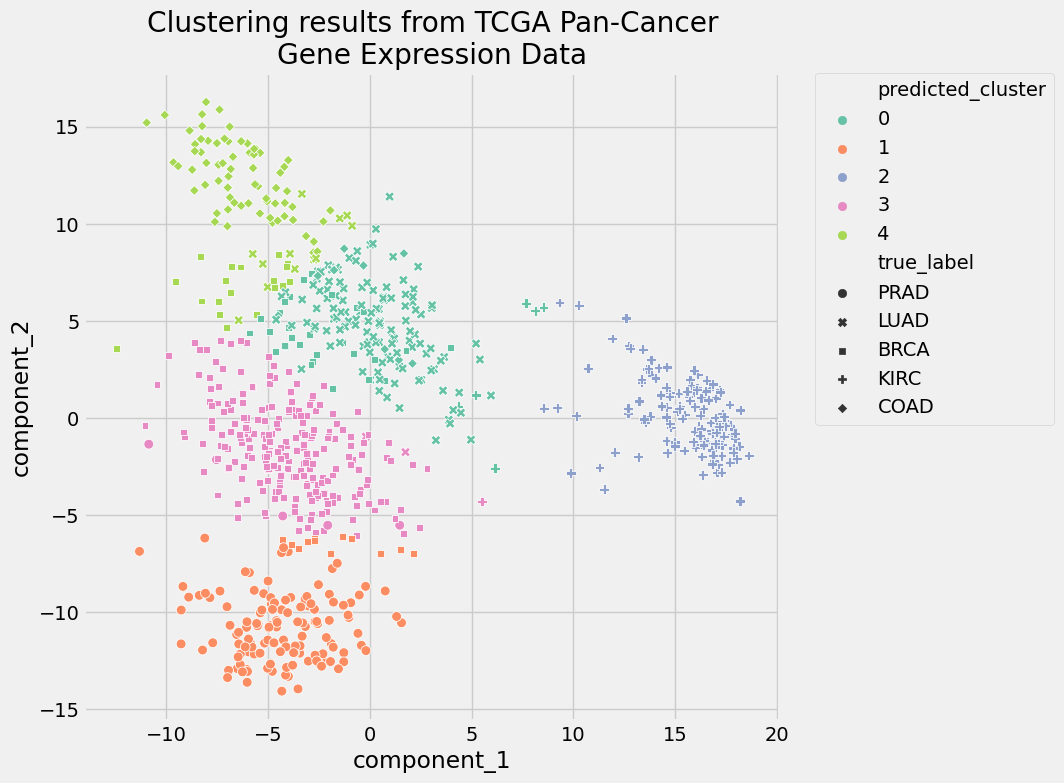

In [17]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    x="component_1",
    y="component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()


<div style="direction:rtl">نمایش تصویری از خوشه‌ها نتایج دو معیار ارزیابی کلاسترینگ را تایید می‌کند. عملکرد لوله شما به خوبی بود. خوشه‌ها تنها کمی همپوشانی داشتند و اختصاص خوشه‌ها به مراتب بهتر از تصادفی بود.